In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read the S&P 500 companies data from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Replace '.' with '-' in the 'Symbol' column to handle ticker symbols with periods
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# Extract unique ticker symbols from the 'Symbol' column
symbols_list = sp500['Symbol'].unique().tolist()

# Define the end date for data retrieval
end_date = '2024-06-24'

# Calculate the start date as 8 years before the end date
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

# Download historical stock price data for the ticker symbols using yfinance
df = yf.download(tickers=symbols_list, start=start_date, end=end_date)

# Stack the dataframe to have a multi-index of 'date' and 'ticker'
df = df.stack()

# Rename the index levels
df.index.names = ['date', 'ticker']

# Convert column names to lowercase
df.columns = df.columns.str.lower()

print(df)

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-24 A        41.401421   44.119999   45.070000   43.919998   44.560001   
           AAL      25.995680   27.049999   28.500000   27.040001   28.200001   
           AAPL     21.446661   23.350000   23.665001   23.162500   23.227501   
           ABBV     42.421848   59.860001   60.599998   59.180000   59.259998   
           ABT      32.720276   37.910000   38.560001   37.910000   38.369999   
...                       ...         ...         ...         ...         ...   
2024-06-21 XYL     138.669998  138.669998  139.179993  137.330002  139.179993   
           YUM     134.289993  134.289993  135.130005  133.369995  135.110001   
           ZBH     107.860001  107.860001  108.059998  106.000000  106.699997   
           ZBRA    300.010010  300.010010  301.170013  293.429993  297.709991   
           ZTS     171.08999

Calculate

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [5]:
# Calculate Garman-Klass Volatility
df['garman_klass_vol'] = (
    (np.log(df['high']) - np.log(df['low']))**2 / 2 -
    (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open']))**2)
)

# Calculate RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Calculate Bollinger Bands
bb = pandas_ta.bbands(close=np.log1p(df['adj close']), length=20)
df['bb_low'] = bb.iloc[:, 0]
df['bb_mid'] = bb.iloc[:, 1]
df['bb_high'] = bb.iloc[:, 2]

# Calculate ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Calculate MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
# Calculate Dollar Volume
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-24 A        41.401421   44.119999   45.070000   43.919998   44.560001   
           AAL      25.995680   27.049999   28.500000   27.040001   28.200001   
           AAPL     21.446661   23.350000   23.665001   23.162500   23.227501   
           ABBV     42.421848   59.860001   60.599998   59.180000   59.259998   
           ABT      32.720276   37.910000   38.560001   37.910000   38.369999   
...                       ...         ...         ...         ...         ...   
2024-06-21 XYL     138.669998  138.669998  139.179993  137.330002  139.179993   
           YUM     134.289993  134.289993  135.130005  133.369995  135.110001   
           ZBH     107.860001  107.860001  108.059998  106.000000  106.699997   
           ZBRA    300.010010  300.010010  301.170013  293.429993  297.709991   
           ZTS     171.089996  171.089996  171.789993  169.350006  169.380005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-24 A         5263600.0         -0.001754        NaN       NaN   
           AAL      36049900.0         -0.001176        NaN       NaN   
           AAPL    301245600.0         -0.002228        NaN       NaN   
           ABBV      9878500.0         -0.042882        NaN       NaN   
           ABT      16525000.0         -0.009656        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-21 XYL       1698300.0          0.000084  51.383498  2.573263   
           YUM       3868100.0          0.000072  42.732219  2.576492   
           ZBH       3318000.0          0.000140  31.530232  2.620058   
           ZBRA       572100.0          0.000316  46.300549  2.808983   
           ZTS       4891600.0          0.000063  50.703938  3.343760   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-06-24 A            NaN       NaN       NaN       NaN     217.920517  
           AAL          NaN       NaN       NaN       NaN     937.141659  
           AAPL         NaN       NaN       NaN       NaN    6460.712260  
           ABBV         NaN       NaN       NaN       NaN     419.064228  
           ABT          NaN       NaN       NaN       NaN     540.702559  
...                     ...       ...       ...       ...            ...  
2024-06-21 XYL     4.388049  6.202835  0.741145 -0.026745     235.503258  
           YUM     4.379031  6.181570  0.344108 -0.685730     519.447123  
           ZBH     4.329821  6.039584 -0.675497 -1.399101     357.879482  
           ZBRA    4.473606  6.138230 -0.185014 -0.528488     171.635727  
           ZTS     4.625922  5.908085  0.545080  0.056958     836.903826  

[991683 rows x 14 columns]

<Axes: xlabel='date'>

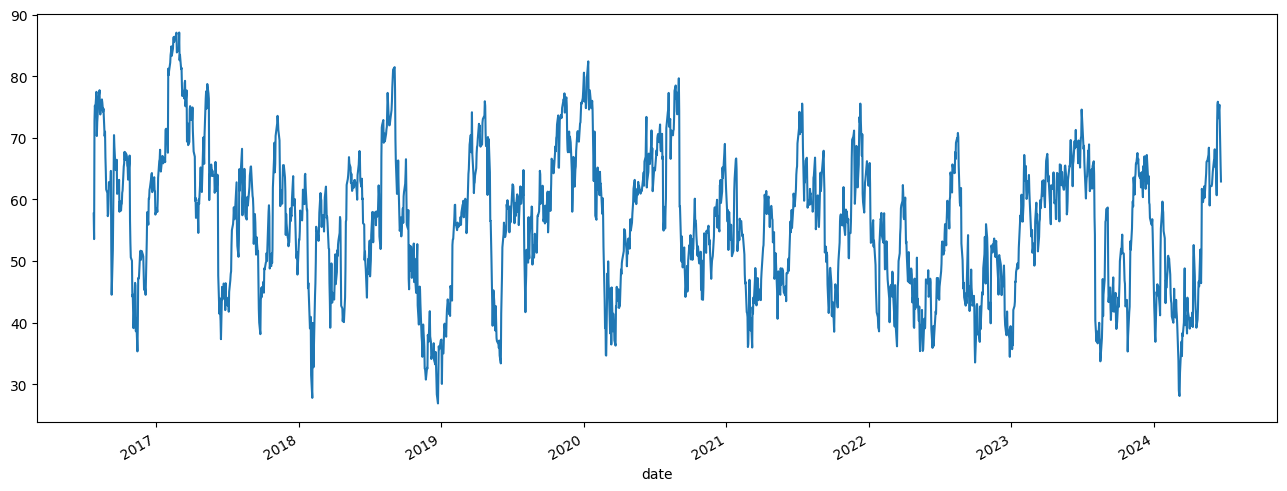

In [6]:
df.xs('AAPL', level=1)["rsi"].plot(figsize=(16,6))

In [7]:
pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
date,,,,,
2016-06-24,NaN,NaN,NaN,NaN,NaN
2016-06-27,NaN,NaN,NaN,NaN,NaN
2016-06-28,NaN,NaN,NaN,NaN,NaN
2016-06-29,NaN,NaN,NaN,NaN,NaN
2016-06-30,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-06-14,179.508475,196.026499,212.544523,16.852848,0.998350
2024-06-17,178.837792,197.366499,215.895207,18.775940,1.020908
2024-06-18,178.852023,198.528999,218.205975,19.822772,0.900493



* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [8]:
df.unstack('ticker')['dollar_volume']

ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-06-24,217.920517,937.141659,6460.712260,419.064228,NaN,540.702559,45.939955,669.705393,399.143007,399.090984,...,170.648778,261.357839,408.912296,248.034776,1237.544206,115.439987,347.799801,727.591928,111.134713,282.417334
2016-06-27,171.635258,562.687245,3845.576991,330.418399,NaN,408.280669,30.399753,351.574748,356.649839,161.552180,...,89.295190,185.748458,434.398677,191.237832,871.107463,65.127788,279.888515,187.486006,124.511180,216.682112
2016-06-28,173.983080,515.203363,3476.690470,420.786453,NaN,271.654803,28.558752,280.101959,306.893229,150.478128,...,83.588083,173.706619,301.955471,94.152941,833.647457,62.369281,338.132899,152.327285,65.937238,159.551655
2016-06-29,98.659402,399.539450,3167.424881,407.725545,NaN,278.520186,21.759869,355.085639,279.913543,118.029582,...,113.568807,159.714808,215.841913,88.829422,890.483328,42.960868,216.295570,146.874528,91.356716,161.269315
2016-06-30,91.031114,303.306979,3146.697956,347.513575,NaN,353.705976,44.352000,367.899022,339.546816,124.480001,...,129.168915,259.793659,211.646776,124.457484,912.740090,71.083216,268.105732,169.864570,50.956708,169.442749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,280.904518,476.833789,14900.372908,738.019568,402.088965,381.863809,159.370240,850.439177,7799.067410,520.732361,...,82.914944,97.962000,238.747688,129.080263,1452.625082,121.885466,194.036605,172.725970,65.939755,379.524922
2024-06-17,275.590619,344.047691,20308.110589,691.615650,771.240600,407.199878,116.730485,1016.372584,3716.149542,561.221849,...,125.546965,98.599874,162.707104,120.104120,2291.586457,164.071124,181.802374,169.021774,92.655358,307.397819
2024-06-18,465.809679,212.532115,17131.049220,728.434227,488.516721,468.058980,150.091205,1516.606747,2206.976275,578.422824,...,158.320953,88.821445,143.112475,226.769275,1942.905953,127.385771,344.075131,187.048912,128.788050,385.755950


In [9]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-08-31 A           87.824765   44.201355 -1.355813  4.891071  2.858783   
           AAL        269.710267   34.989559  0.021083  4.885122  2.836946   
           AAPL      2718.975663   24.494835 -1.314338  4.875742  2.765724   
           ABBV       309.214764   45.825466 -1.496343  4.880948  2.772697   
           ABT        377.320452   36.491035 -1.189069  4.860088  2.753221   
...                          ...         ...       ...       ...       ...   
2024-06-30 XYL        156.030146  138.669998  0.741145  6.202835  2.573263   
           YUM        271.877713  134.289993  0.344108  6.181570  2.576492   
           ZBH        191.786214  107.860001 -0.675497  6.039584  2.620058   
           ZBRA        84.261003  300.010010 -0.185014  6.138230  2.808983   
           ZTS        408.150142  171.089996  0.545080  5.908085  3.343760   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-08-31 A       3.874927         -0.001547 -0.074325  50.593762  
           AAL     3.861034         -0.000479  1.175455  59.580611  
           AAPL    3.820733         -0.002162 -0.126981  57.609113  
           ABBV    3.826823         -0.043844 -0.251643  44.707526  
           ABT     3.806655         -0.009720 -0.211829  40.903716  
...                     ...               ...       ...        ...  
2024-06-30 XYL     4.388049          0.000084 -0.026745  51.383498  
           YUM     4.379031          0.000072 -0.685730  42.732219  
           ZBH     4.329821          0.000140 -1.399101  31.530232  
           ZBRA    4.473606          0.000316 -0.528488  46.300549  
           ZTS     4.625922          0.000063  0.056958  50.703938  

[46849 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [10]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-07-31 AAL      48.955452  0.792261  5.057411  2.974725  4.016068   
           AAPL     34.805637 -1.143731  5.052025  2.934802  3.993414   
           ABBV     51.918198 -1.272234  5.056885  2.947161  4.002023   
           ABT      43.763512 -1.319409  5.035975  2.927854  3.981914   
           ACN     115.969193 -1.241117  5.060991  3.099739  4.080365   
...                       ...       ...       ...       ...       ...   
2024-06-30 VZ       40.240002 -0.686259  6.982087  2.748129  4.865108   
           WFC      58.099998  0.016774  6.625461  2.254007  4.439734   
           WMT      67.910004  0.891511  6.518932  2.293722  4.406327   
           XOM     110.760002  0.615747  6.145629  2.508481  4.327055   
           ZTS     171.089996  0.545080  5.908085  3.343760  4.625922   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-07-31 AAL            -0.000281  0.276867  49.738428  
           AAPL           -0.002001 -0.172229  50.672345  
           ABBV           -0.036168 -0.109611  45.182696  
           ABT            -0.005979  0.286953  55.959065  
           ACN            -0.004038  0.092777  60.835364  
...                             ...       ...        ...  
2024-06-30 VZ              0.000067 -0.040259  50.928993  
           WFC             0.000189 -0.519504  46.943631  
           WMT             0.000046  2.357286  69.284248  
           XOM             0.000110 -1.400685  43.634695  
           ZTS             0.000063  0.056958  50.703938  

[12516 rows x 8 columns]

* Calculate Monthly Returns for different time horizons as features.


In [11]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12] # different months calculations

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-07-31 AAL      38.702713  0.787451  5.254236  2.964579  4.109408   
           AAPL     45.223690 -1.066717  5.253382  2.956741  4.105061   
           ABBV     70.902931  0.053092  5.270216  2.975981  4.123098   
           ABT      59.436672 -0.934989  5.248739  2.968110  4.108425   
           ACN     146.102753 -0.828612  5.289193  3.132231  4.210712   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    468.709991  1.177638  6.895573  3.260171  5.077872   
           VZ       40.240002 -0.686259  6.982087  2.748129  4.865108   
           WFC      58.099998  0.016774  6.625461  2.254007  4.439734   
           WMT      67.910004  0.891511  6.518932  2.293722  4.406327   
           XOM     110.760002  0.615747  6.145629  2.508481  4.327055   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-07-31 AAL             0.000092 -0.309499  49.117696   0.041623   
           AAPL           -0.000885 -0.157778  52.605274   0.027983   
           ABBV           -0.025348 -0.727002  45.920926   0.005633   
           ABT            -0.003467  0.523905  62.882491   0.079433   
           ACN            -0.003209 -0.172870  42.887827  -0.026041   
...                             ...       ...        ...        ...   
2024-06-30 VRTX            0.000119  2.229086  59.836299   0.029363   
           VZ              0.000067 -0.040259  50.928993  -0.022114   
           WFC             0.000189 -0.519504  46.943631  -0.030374   
           WMT             0.000046  2.357286  69.284248   0.032695   
           XOM             0.000110 -1.400685  43.634695  -0.055432   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393  
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060  
           ABBV    -0.029587  -0.011801  -0.028860   0.005495    0.026310  
           ABT      0.034389   0.042361   0.010427   0.022867    0.025837  
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435  
...                      ...        ...        ...        ...         ...  
2024-06-30 VRTX     0.092348   0.038897   0.023854   0.033726    0.024172  
           VZ       0.009451  -0.008560   0.016465   0.030418    0.012618  
           WFC     -0.007496   0.002719   0.030214   0.042387    0.028553  
           WMT      0.071536   0.042361   0.044856   0.028467    0.023055  
           XOM     -0.028348  -0.013311   0.020156  -0.003694    0.005583  

[10365 rows x 14 columns]